In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from pathlib import Path
import os
import random

In [2]:
data_folder = Path(os.path.abspath("")).parent / "data/raw"
data_folder

PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw')

In [3]:
data_folder.ls()

[PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/test_images'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train.csv'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images.zip'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/sample_submission.csv'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/new_train.csv'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_labels'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/.gitkeep'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images'),
 PosixPath('/home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/test_images.zip')]

In [4]:
train_df = pd.read_csv(data_folder / "train.csv")
test_df = pd.read_csv(data_folder / "sample_submission.csv")

In [5]:
# Modifying dataframe to suit the api
train_df['Class'] = train_df.Image_Label.apply(lambda x: x.split('_')[1])

In [6]:
# Correct the name of images
train_df['Image_Label'] = train_df.Image_Label.apply(lambda x: x.split('_')[0])

In [7]:
# Long to wide, rles to each columns
train_df = train_df.pivot(index='Image_Label', columns='Class', values='EncodedPixels')

In [8]:
train_df.reset_index(inplace=True)
train_df

Class,Image_Label,Fish,Flower,Gravel,Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN
1,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...
2,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...
3,0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN
4,003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...
...,...,...,...,...,...
5541,ffcedf2.jpg,12631 4 12638 3 12649 16 13377 8 13395 13 1341...,NaN,NaN,NaN
5542,ffd11b6.jpg,NaN,425921 5 425929 4 425945 2 425949 1 425952 1 4...,NaN,1457936 458 1459336 458 1460736 458 1462136 45...
5543,ffd3dfb.jpg,NaN,NaN,NaN,12891 428 14291 428 15691 428 17091 428 18491 ...
5544,ffd6680.jpg,NaN,1509467 305 1509773 7 1509782 2 1510867 310 15...,39728 823 41128 823 42528 823 43928 823 45328 ...,NaN


In [9]:
train_df[train_df.isna()] = '1 1'

In [10]:
train_df.to_csv(data_folder / 'new_train.csv', index=False)

In [11]:
src_size = np.array((1400, 2100))
src_size = src_size /4
src_size = src_size.astype(int)
src_size

array([350, 525])

In [12]:
bs = 2

In [13]:
class MultiClassSegList(SegmentationLabelList):
    def open(self, id_rles):
        image_id, rles = id_rles[0], id_rles[1:]
        shape = open_image(self.path/image_id).shape[-2:]       
        final_mask = torch.zeros((1, *shape))
        for k, rle in enumerate(rles):
            if isinstance(rle, str):
                mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
                final_mask += (k+1)*mask
        return ImageSegment(final_mask)

In [20]:
train_df.head()

Class,Image_Label,Fish,Flower,Gravel,Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,1 1,1 1
1,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,1 1,67495 350 68895 350 70295 350 71695 350 73095 ...
2,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,1 1,658170 388 659570 388 660970 388 662370 388 66...
3,0035239.jpg,1 1,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,1 1
4,003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,1 1,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...


In [22]:
data = (SegmentationItemList
     .from_csv(data_folder/"train_images", data_folder / 'new_train.csv')
     .split_by_rand_pct(valid_pct=0.2)
     .label_from_df(cols=list(range(5)), label_cls=MultiClassSegList, classes=[1, 2, 3, 4])
     .transform(get_transforms(), size=src_size, tfm_y=True)
     .databunch(bs=bs)
     .normalize(imagenet_stats)
)
data

ImageDataBunch;

Train: LabelList (4437 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: MultiClassSegList
ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images;

Valid: LabelList (1109 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: MultiClassSegList
ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525)
Path: /home/pankaj/Pankaj/Learning/Kaggle/cloud/data/raw/train_images;

Test: None

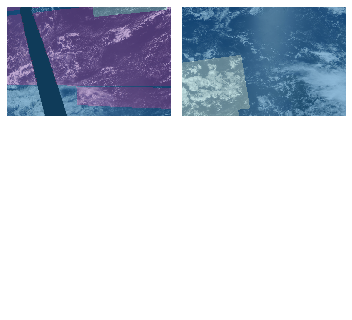

In [23]:
data.show_batch(2, figsize=(5,5))

In [24]:
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, wd=wd)

In [26]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:93